# Run MOFA model on CITE data

In [1]:
import scanpy as sc
import muon as mu
import mofax as mofa
import mofapy2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import anndata as ad

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preprocessing

In [2]:
## read the data
Cite_data = sc.read_h5ad("/mnt/storage/thien/projectdata/GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad")
print(Cite_data)

AnnData object with n_obs × n_vars = 90261 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
## the two modalities are stored in the same anndata object
set(Cite_data.var["feature_types"])

## prepare the dataset -> store data types in separate anndata objects within one dict
Cite_ADT = Cite_data[:,Cite_data.var["feature_types"]=="ADT"].copy()
Cite_GEX = Cite_data[:,Cite_data.var["feature_types"]=="GEX"].copy()

In [4]:
## store shared features for the GEX data, such that after variance filtering, these genes can again be added to the GEX data
shared_features = [name for name in list(Cite_ADT.var_names) if name in list(Cite_GEX.var_names)]
GEX_shared_features = Cite_GEX[:,shared_features] ### 

In [5]:
## preprocessing 
## ADT is already normalized, but with CLR instead of DSB --> ??

# GEX 
## data is already normalized
# log transformation
sc.pp.log1p(Cite_GEX)

## filter for highly variable genes (threshold as in tutorial https://muon-tutorials.readthedocs.io/en/latest/cite-seq/1-CITE-seq-PBMC-5k.html)
sc.pp.highly_variable_genes(Cite_GEX,min_mean=0.02, max_mean=4, min_disp=0.5, inplace=True)
Cite_GEX = Cite_GEX[:, Cite_GEX.var.highly_variable]

# save preprocessed data 
#Cite_GEX.write_h5ad("/mnt/storage/anna/Cite_GEX_preprocessed.h5ad")
#Cite_ADT.write_h5ad("/mnt/storage/anna/Cite_ADT_preprocessed.h5ad")

In [6]:
Cite_GEX

View of AnnData object with n_obs × n_vars = 90261 × 2701
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dataset_id', 'genome', 'organism', 'log1p', 'hvg'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [7]:
## which shared features had been removed during variance filtering?
removed_shared_features = [name for name in list(GEX_shared_features.var_names) if name not in list(Cite_GEX.var_names)]
## add these again to the filtered GEX object
GEX_removed_features = GEX_shared_features[:,removed_shared_features] ### 
GEX_with_shared = ad.concat([ Cite_GEX, GEX_removed_features], axis = 1, merge="same")


# save preprocessed data 
GEX_with_shared.write_h5ad("/mnt/storage/anna/Cite_GEX_with_shared_preprocessed.h5ad")
#Cite_ADT.write_h5ad("/mnt/storage/anna/Cite_ADT_preprocessed.h5ad")

In [8]:
GEX_with_shared

AnnData object with n_obs × n_vars = 90261 × 2732
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

/home/anna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


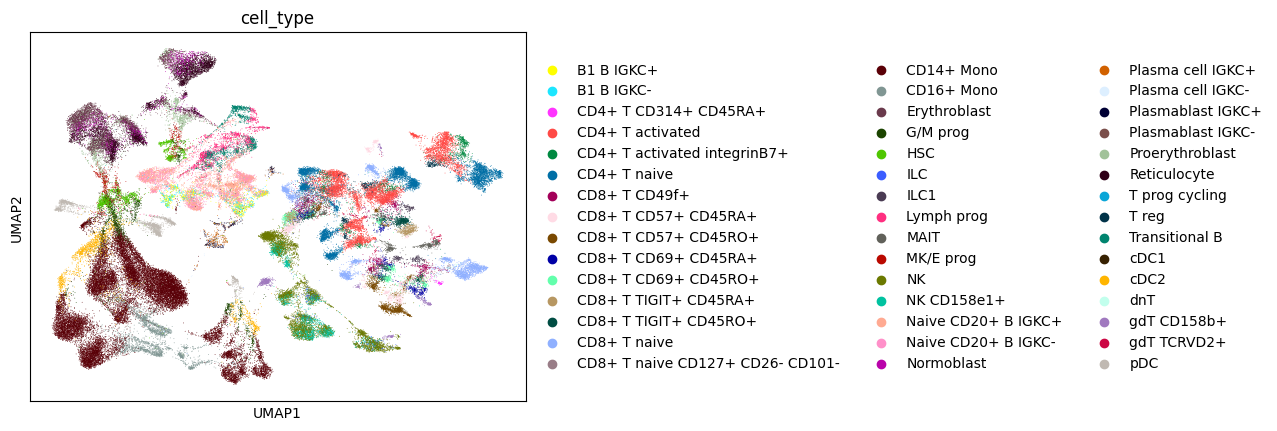

In [39]:
#visualize in UMAP
sc.pp.pca(Cite_ADT)
sc.pp.neighbors(Cite_ADT, n_neighbors=15)
sc.tl.umap(Cite_ADT, random_state=1)#set random state to ensure reproducibility
sc.pl.umap(Cite_ADT, color="cell_type")


/home/anna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/anna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/anna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/anna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


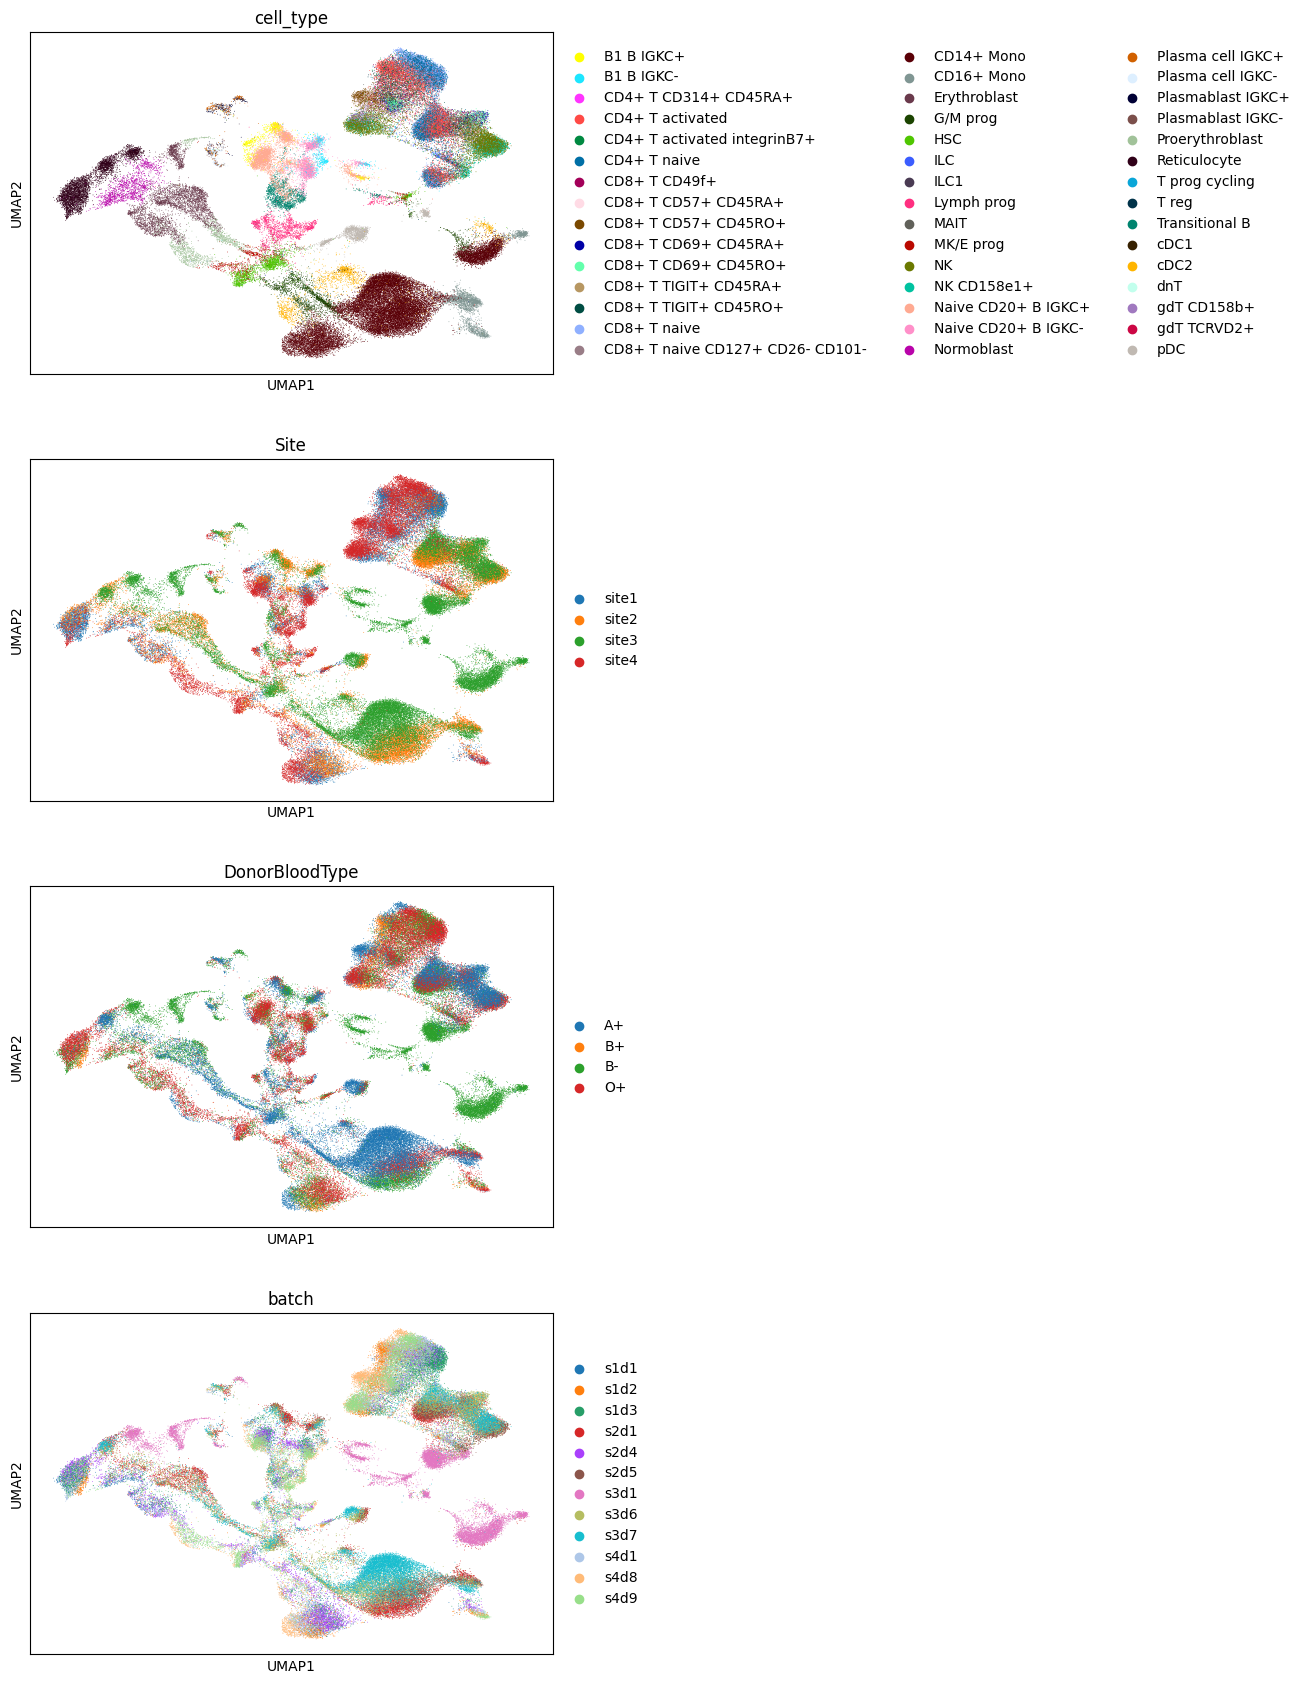

In [30]:
#visualize in UMAP
#sc.pp.pca(Cite_GEX)
#sc.pp.neighbors(Cite_GEX, n_neighbors=15)
#sc.tl.umap(Cite_GEX, random_state=1)#set random state to ensure reproducibility
sc.pl.umap(Cite_GEX, color=["cell_type", "Site", "DonorBloodType", "batch"], ncols = 1)

### MOFA analysis

In [3]:
Cite_GEX = sc.read_h5ad("/mnt/storage/anna/data/Cite_GEX_preprocessed.h5ad")
Cite_ADT = sc.read_h5ad("/mnt/storage/anna/data/Cite_ADT_preprocessed.h5ad")

In [4]:
## set up data for MOFA
mods = {
    "ADT" : Cite_ADT, 
    "GEX" : Cite_GEX
}

mdata = mu.MuData(mods)

## two modalities with metadata 
mdata

/home/anna/.local/lib/python3.8/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


MuData object with n_obs × n_vars = 90261 × 2835
  2 modalities
    ADT:	90261 x 134
      obs:	'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
      var:	'feature_types', 'gene_id'
      uns:	'dataset_id', 'genome', 'organism'
      obsm:	'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
      layers:	'counts'
    GEX:	90261 x 2701
      obs:	'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
      var:	'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'dataset_id', 'genome', 'hvg', 'log1p', 'organism'
      obsm:	'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
      layers:	'counts'

In [6]:
nfactors = [5, 10, 15]
for n in nfactors: 
    mdata = mu.MuData(mods)
    ## Run mofa
    mu.tl.mofa(mdata,
            n_factors=n,
            outfile=f"/mnt/storage/anna/mofa_cite_{n}_factors.hdf5")

/home/anna/.local/lib/python3.8/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(



        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='ADT' group='group1' with N=90261 samples and D=134 features...
Loaded view='GEX' group='group1' with N=90261 samples and D=2701 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: T

In [6]:
# load models
cite_mofa_5 = mofa.mofa_model("/mnt/storage/anna/models/mofa_cite_5_factors.hdf5")

cite_mofa_10 = mofa.mofa_model("/mnt/storage/anna/models/mofa_cite_10_factors.hdf5")

cite_mofa_15 = mofa.mofa_model("/mnt/storage/anna/models/mofa_cite_15_factors.hdf5")

In [9]:
# Total variance explained for the model with 5 factors
total_f5 = cite_mofa_5.get_r2().groupby(['View']).sum()
total_f5['n_factors'] = 5

# Total variance explained for the model with 15 factors
total_f10 = cite_mofa_10.get_r2().groupby(['View']).sum()
total_f10['n_factors'] = 10
total_variance = pd.concat([total_f5, total_f10]).reset_index()


# Total variance explained for the model with 15 factors
total_f15 = cite_mofa_15.get_r2().groupby(['View']).sum()
total_f15['n_factors'] = 15
total_variance = pd.concat([total_f5,total_f10, total_f15]).reset_index()

<Axes: xlabel='View', ylabel='R2'>

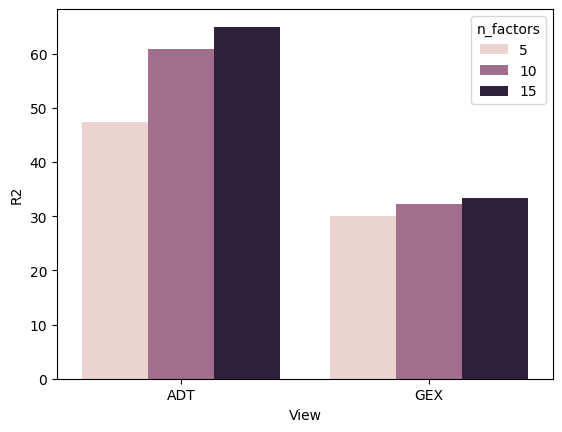

In [18]:
sns.barplot(total_variance, x = 'View', y = 'R2', hue = 'n_factors')

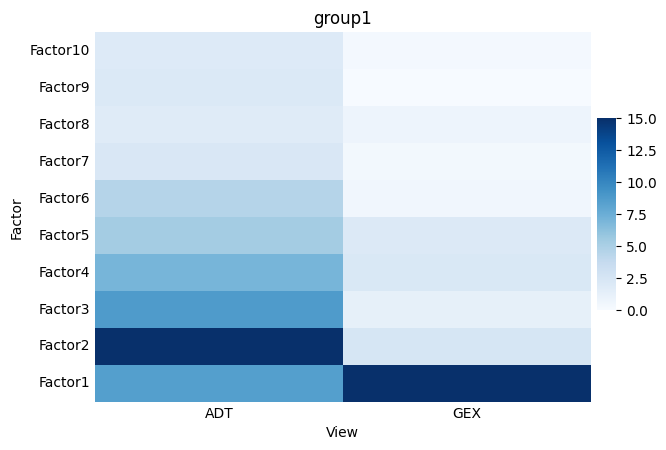

In [4]:
mofa.plot_r2(cite_mofa_10, x = "View", vmax = 15)

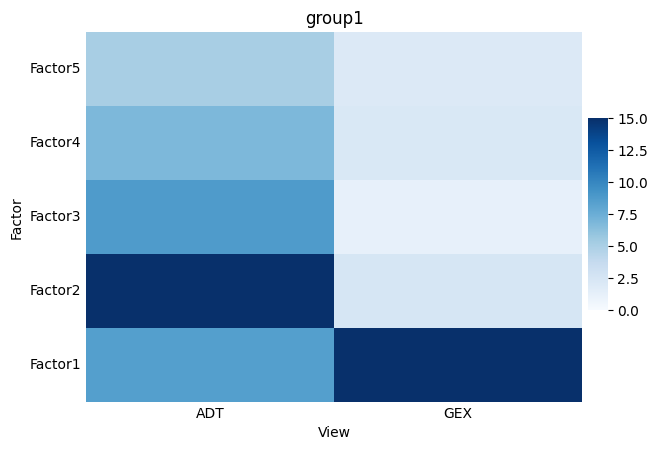

In [20]:
mofa.plot_r2(cite_mofa_5, x = "View", vmax = 15)

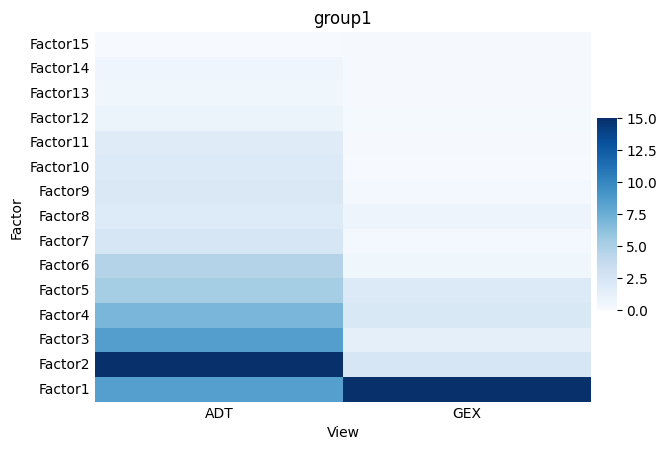

In [11]:
mofa.plot_r2(cite_mofa_15, x = "View", vmax = 15)

In [21]:
print(cite_mofa_5.cells_metadata.columns)

Index(['group', 'ADT:ADT_iso_count', 'ADT:ADT_n_antibodies_by_counts',
       'ADT:ADT_pseudotime_order', 'ADT:ADT_total_counts', 'ADT:DonorAge',
       'ADT:DonorBMI', 'ADT:DonorBloodType', 'ADT:DonorGender', 'ADT:DonorID',
       'ADT:DonorNumber', 'ADT:DonorRace', 'ADT:DonorSmoker', 'ADT:Ethnicity',
       'ADT:GEX_n_genes_by_counts', 'ADT:GEX_pct_counts_mt', 'ADT:GEX_phase',
       'ADT:GEX_pseudotime_order', 'ADT:GEX_size_factors', 'ADT:Modality',
       'ADT:QCMeds', 'ADT:Samplename', 'ADT:Site', 'ADT:VendorLot',
       'ADT:batch', 'ADT:cell_type', 'ADT:is_train', 'GEX:ADT_iso_count',
       'GEX:ADT_n_antibodies_by_counts', 'GEX:ADT_pseudotime_order',
       'GEX:ADT_total_counts', 'GEX:DonorAge', 'GEX:DonorBMI',
       'GEX:DonorBloodType', 'GEX:DonorGender', 'GEX:DonorID',
       'GEX:DonorNumber', 'GEX:DonorRace', 'GEX:DonorSmoker', 'GEX:Ethnicity',
       'GEX:GEX_n_genes_by_counts', 'GEX:GEX_pct_counts_mt', 'GEX:GEX_phase',
       'GEX:GEX_pseudotime_order', 'GEX:GEX_size_

/home/anna/.local/lib/python3.8/site-packages/mofax/plot_utils.py:190: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/home/anna/.local/lib/python3.8/site-packages/mofax/plot_utils.py:190: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/home/anna/.local/lib/python3.8/site-packages/mofax/plot_utils.py:190: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/home/anna/.local/lib/python3.8/site-packages/mofax/plot_utils.py:190: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/home/anna/.local/lib/python3.8/site-packages/mofax/plot_utils.py:190: UserWarning: Tight layout not applied. tight_layout canno

<Axes: title={'center': 'GEX:DonorBMI'}, xlabel='Factor8', ylabel='Factor9'>

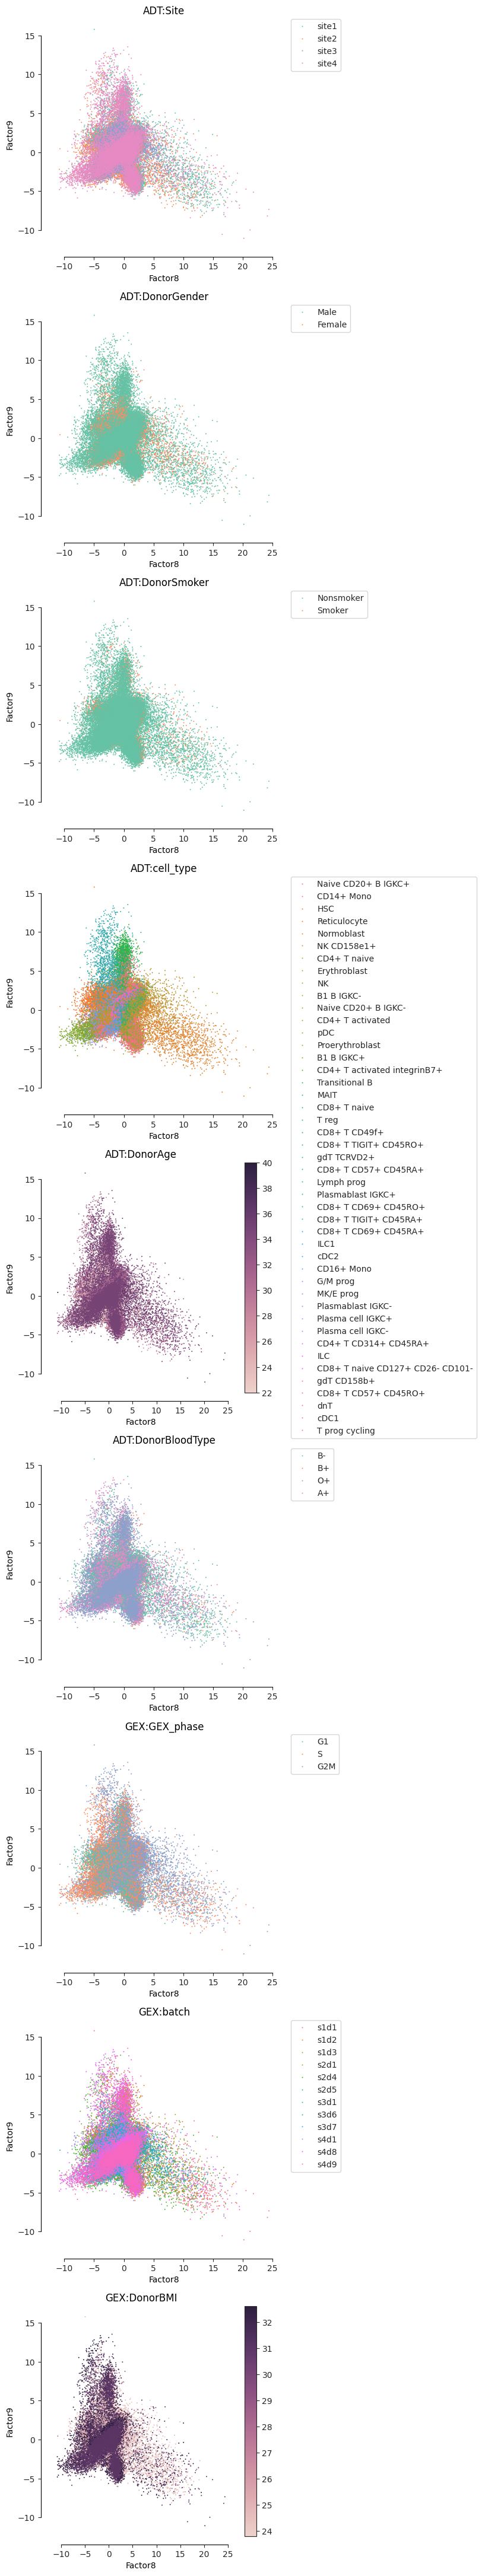

In [20]:
# Plotting the samples in the learned factor space 
mofa.plot_factors(cite_mofa_15, x = "Factor8", y="Factor9",  size=2, color =[ "ADT:Site", "ADT:DonorGender", "ADT:DonorSmoker", "ADT:cell_type", "ADT:DonorAge" ,"ADT:DonorBloodType", "GEX:GEX_phase", "GEX:batch", "GEX:DonorBMI"], ncols = 1)


/home/anna/.local/lib/python3.8/site-packages/mofax/plot_utils.py:190: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/home/anna/.local/lib/python3.8/site-packages/mofax/plot_utils.py:190: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/home/anna/.local/lib/python3.8/site-packages/mofax/plot_utils.py:190: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


<Axes: title={'center': 'ADT:DonorBloodType'}, xlabel='Factor8', ylabel='Factor9'>

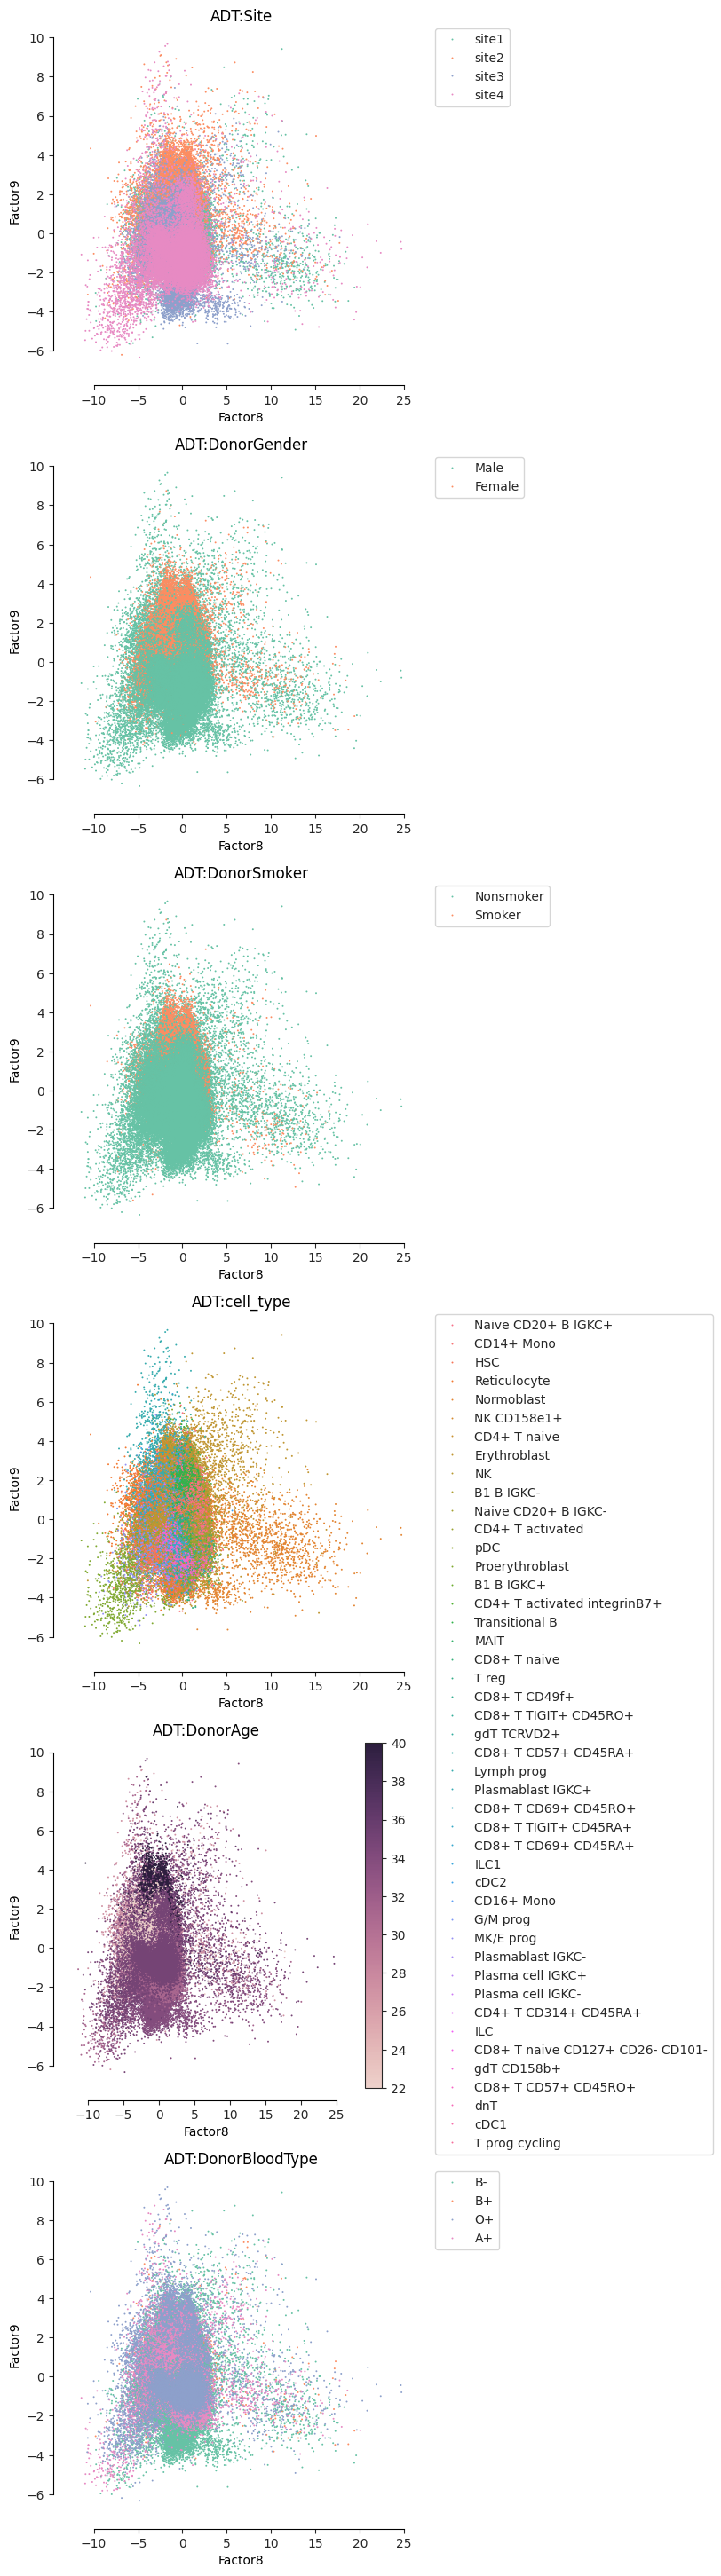

In [22]:
# Plotting the samples in the learned factor space 
mofa.plot_factors(cite_mofa_10, x = "Factor8", y="Factor9",  size=2, color =[ "ADT:Site", "ADT:DonorGender", "ADT:DonorSmoker", "ADT:cell_type", "ADT:DonorAge" ,"ADT:DonorBloodType"], ncols = 1)


<Axes: title={'center': 'ADT:DonorBloodType'}, xlabel='Factor1', ylabel='Factor2'>

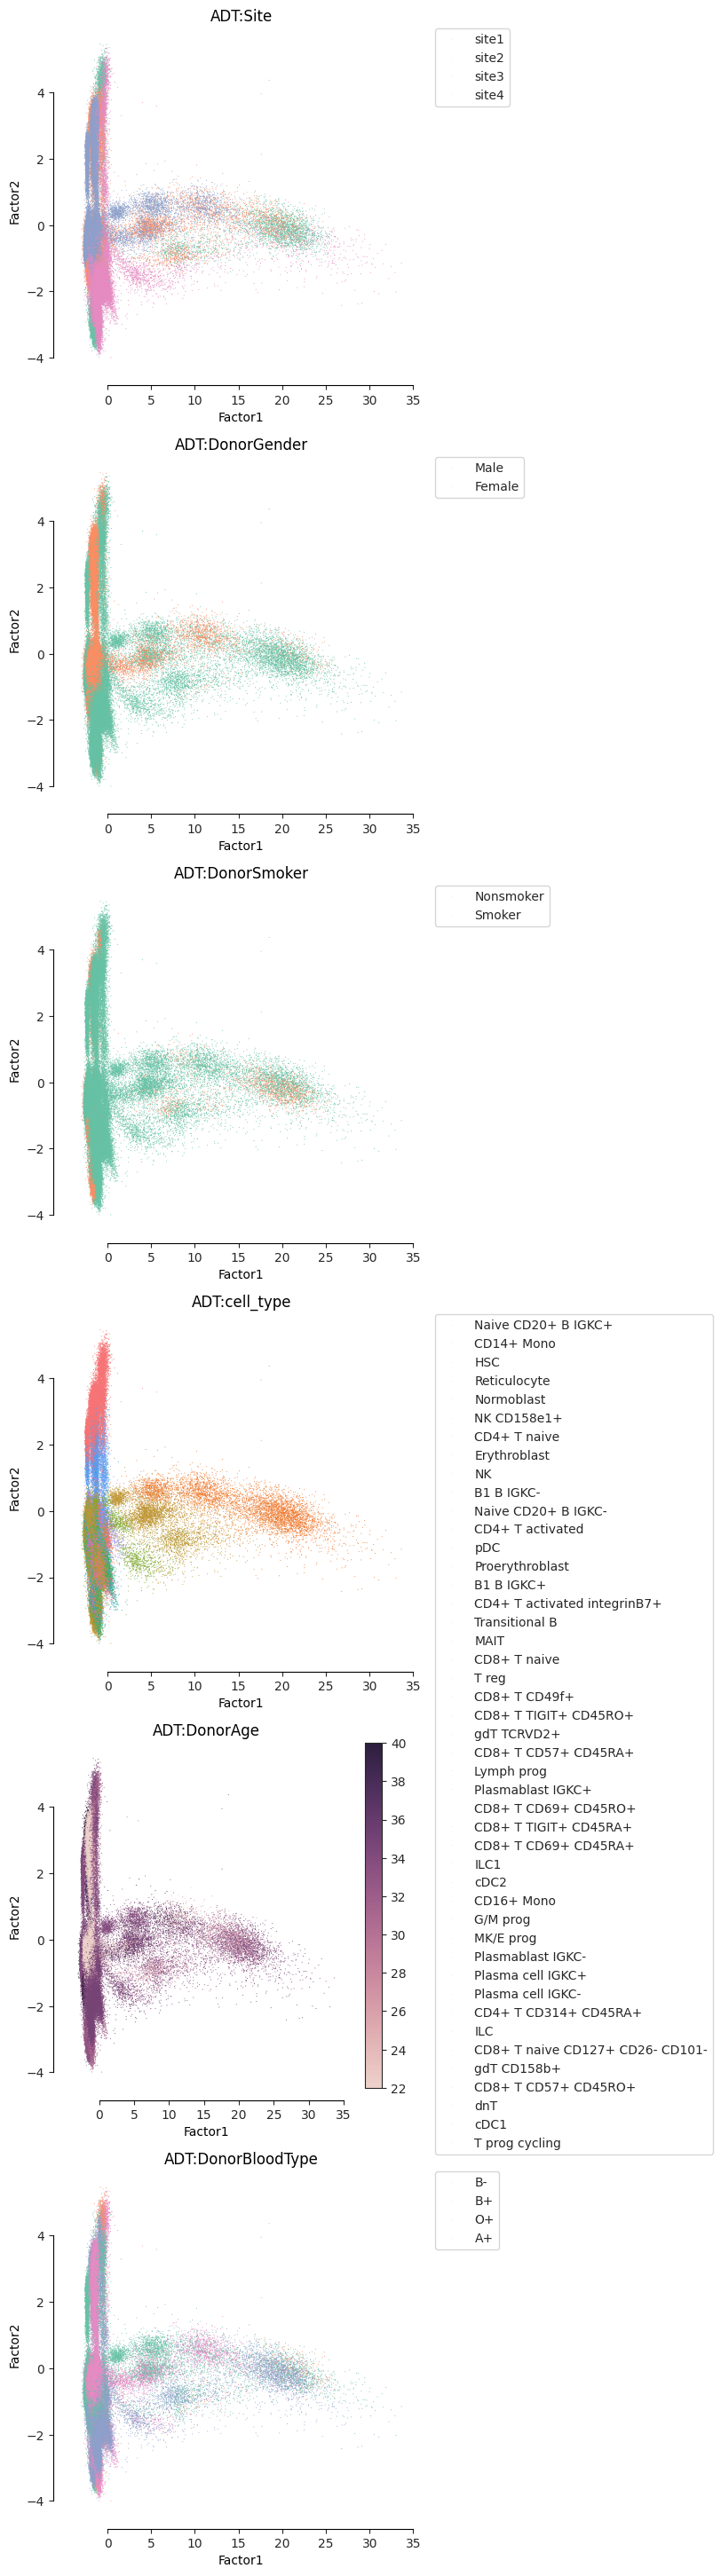

In [27]:
# Plotting the samples in the learned factor space 
mofa.plot_factors(cite_mofa_10, x = "Factor1", y="Factor2",  size=0.5, color =[ "ADT:Site", "ADT:DonorGender", "ADT:DonorSmoker", "ADT:cell_type", "ADT:DonorAge" ,"ADT:DonorBloodType"], ncols = 1)

<Axes: title={'center': 'ADT'}, xlabel='Feature weight'>

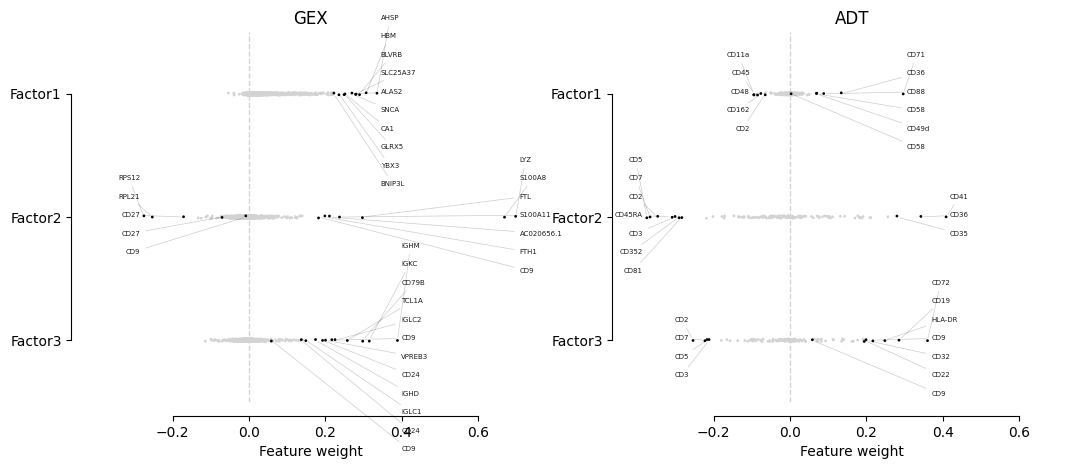

In [46]:
### use model with 10 factors 
mofa.plot_weights(cite_mofa_10, views=['ADT', 'GEX'], factors= range(3), zero_line=True, ncols=3, label_size=5,  n_features = 10)

/home/anna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/anna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/anna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/anna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/anna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/anna/.loc

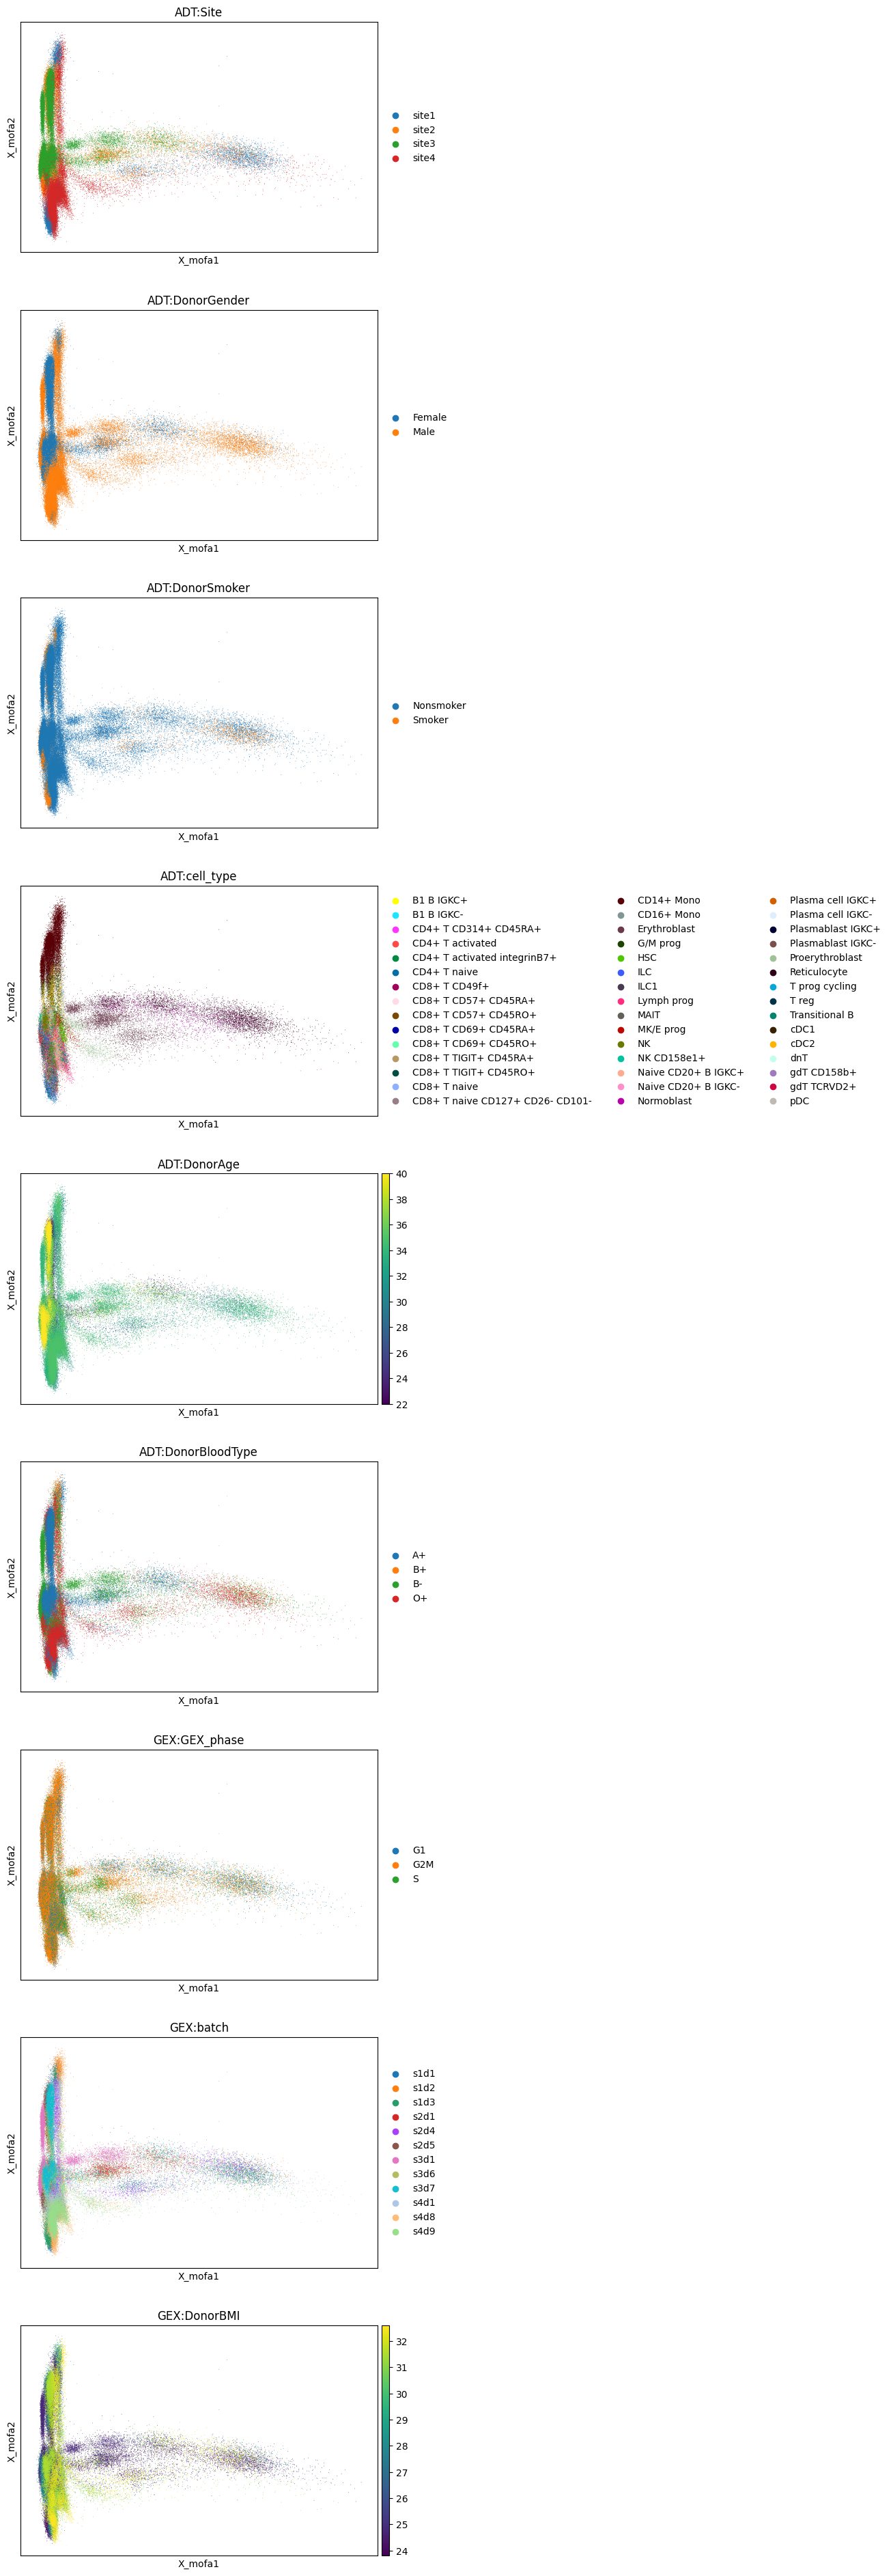

In [41]:
mu.pl.mofa(mdata, color =[ "ADT:Site", "ADT:DonorGender", "ADT:DonorSmoker", "ADT:cell_type", "ADT:DonorAge" ,"ADT:DonorBloodType", "GEX:GEX_phase", "GEX:batch", "GEX:DonorBMI"], ncols = 1)

In [17]:
## show umap view of mofa embedding
mdata.obsm["X_mofa"] = cite_mofa_10.get_factors()
sc.pp.neighbors(mdata, use_rep="X_mofa")
sc.tl.umap(mdata, random_state=1)

/home/anna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/anna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/anna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/anna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/anna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/anna/.loc

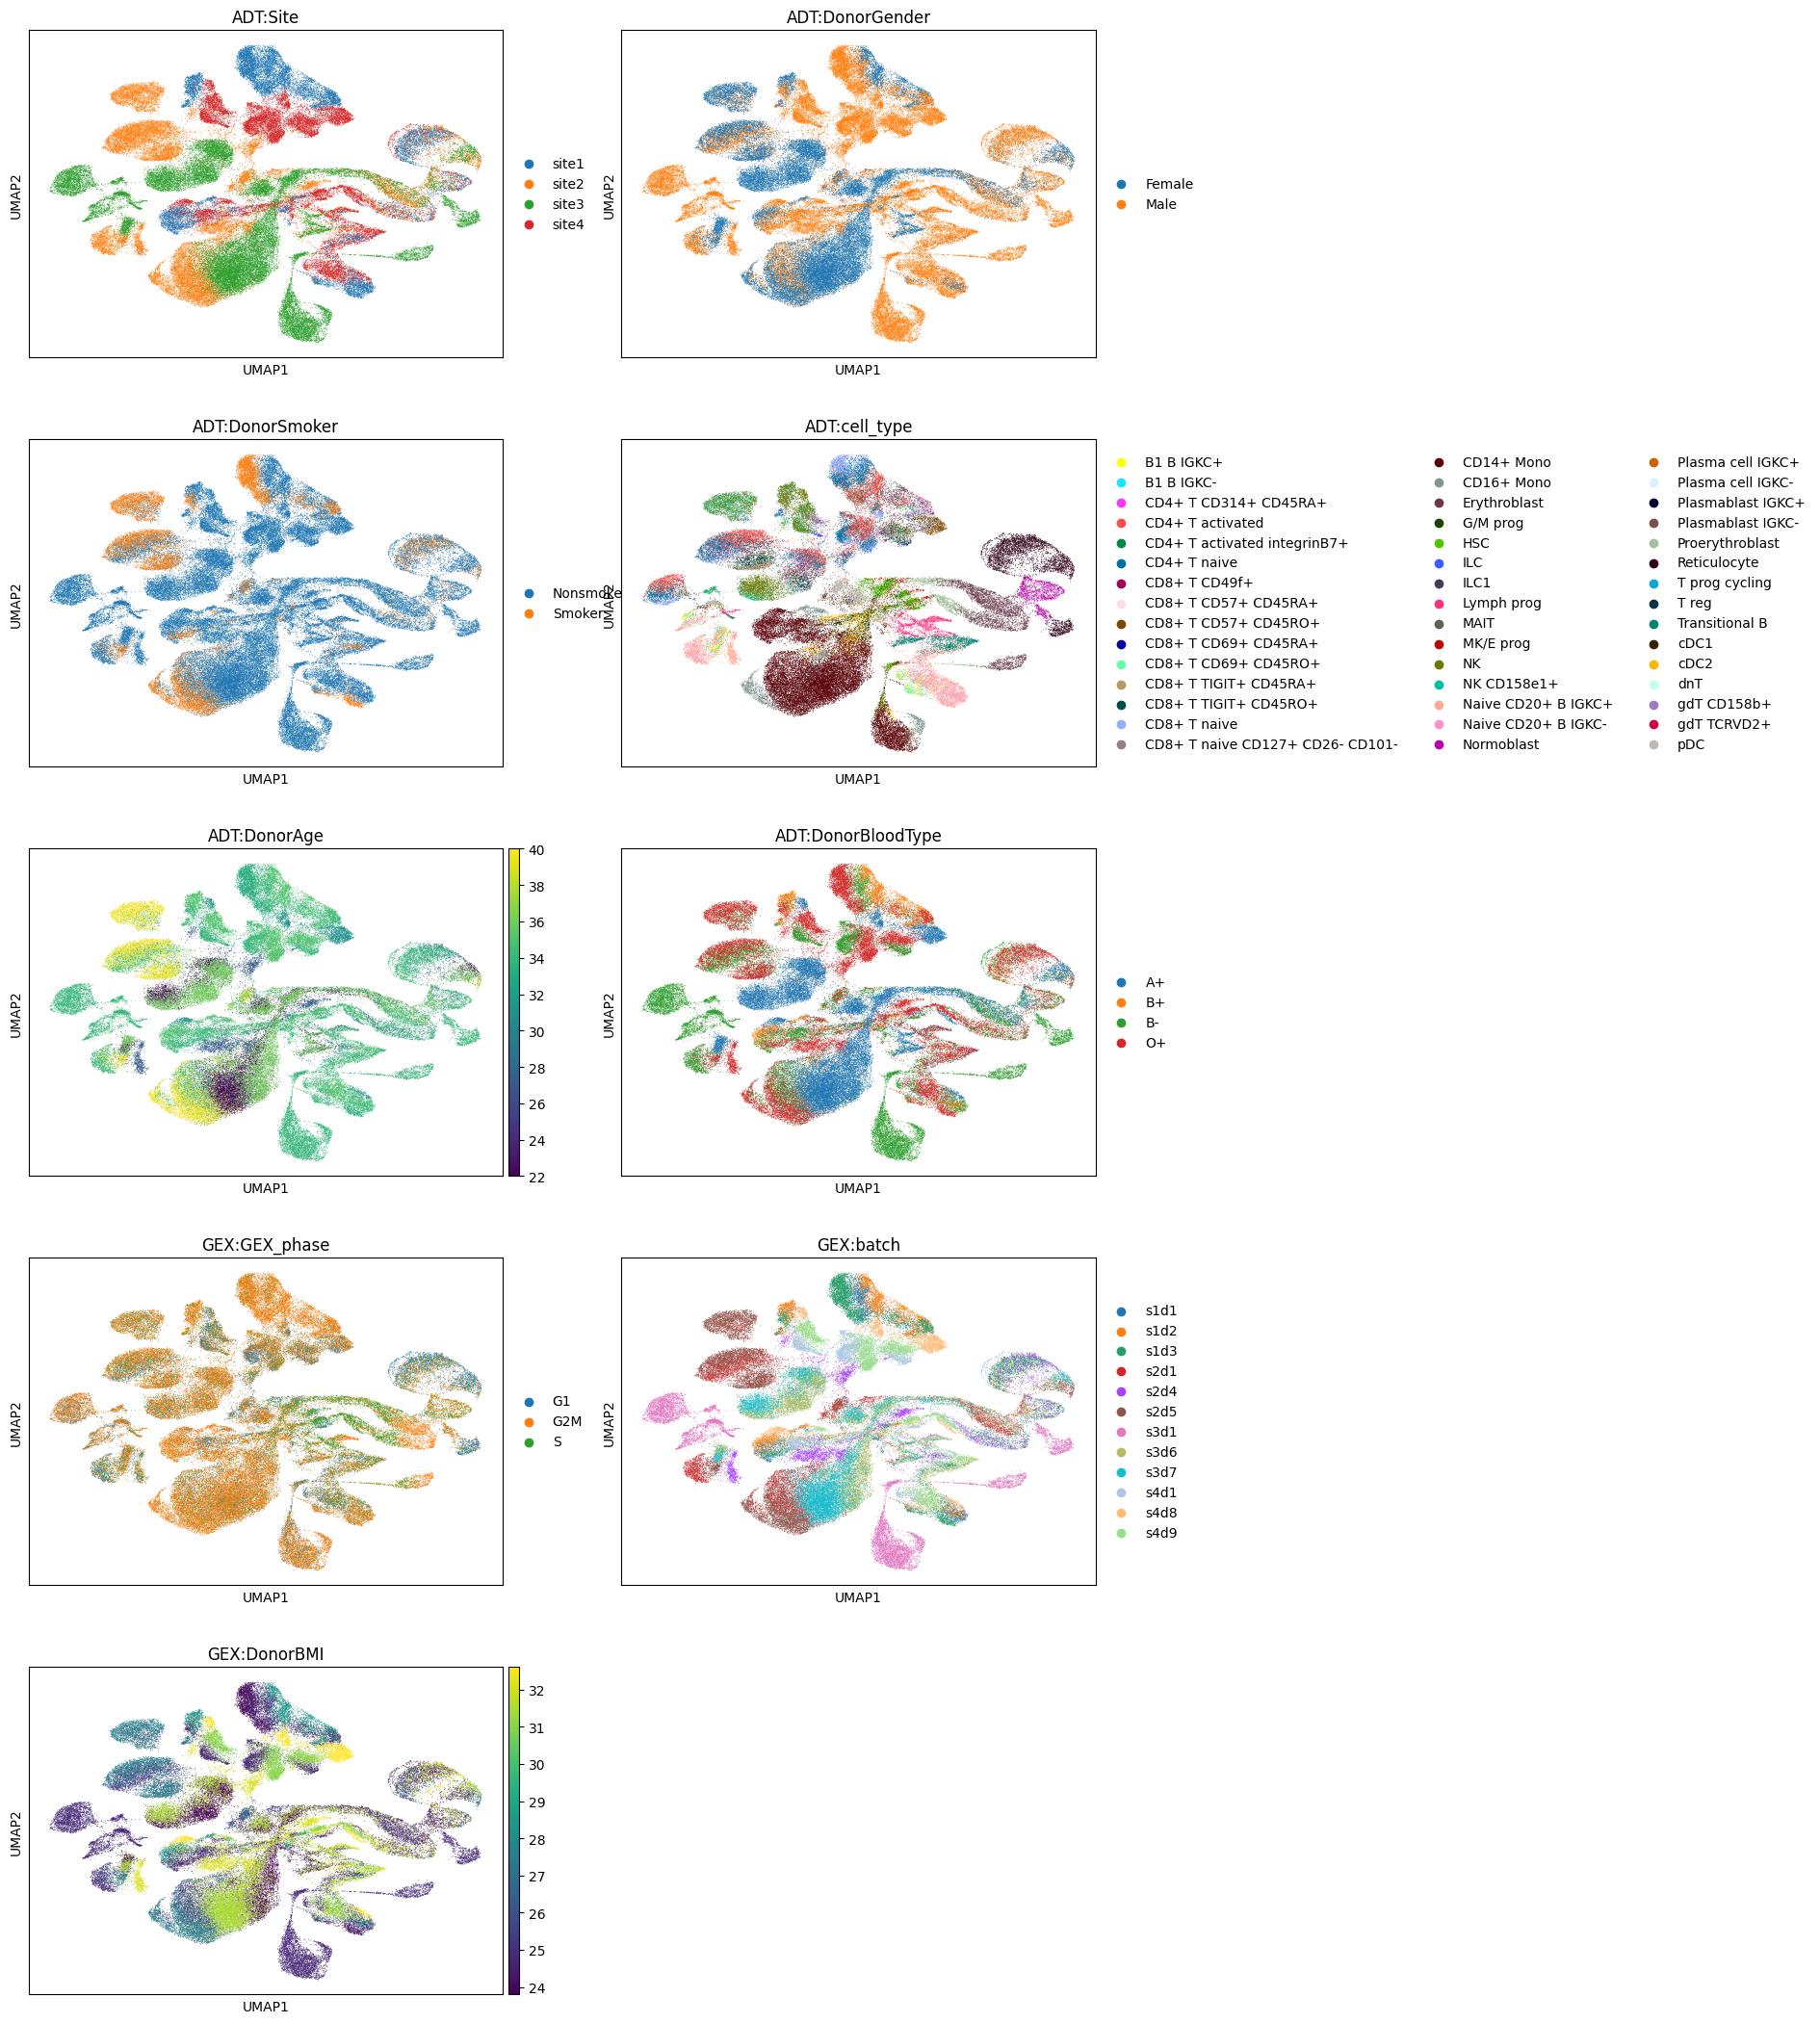

In [18]:
sc.pl.umap(mdata, color =[ "ADT:Site", "ADT:DonorGender", "ADT:DonorSmoker", "ADT:cell_type", "ADT:DonorAge" ,"ADT:DonorBloodType", "GEX:GEX_phase", "GEX:batch", "GEX:DonorBMI"], ncols = 2)

In [52]:
cite_mofa_10.metadata["GEX:cell_type"] = cite_mofa_10.metadata["GEX:cell_type"].astype('category').cat.reorder_categories(mods['GEX'].obs.cell_type.cat.categories)


AttributeError: PolyCollection.set() got an unexpected keyword argument 's'

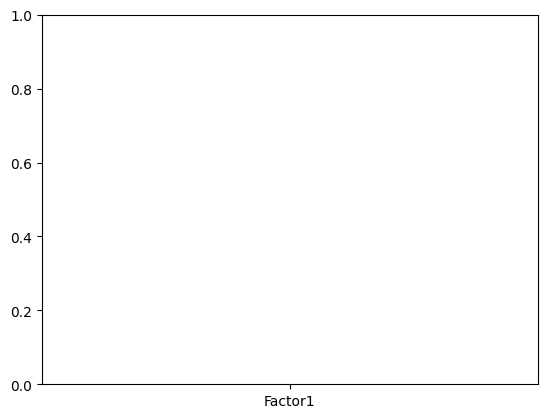

In [56]:
mofa.plot_factors_violin(cite_mofa_10, color='GEX:cell_type', factors=range(3),palette='rainbow')